In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import PHARO_MED_FULL as PHARO
from scipy.ndimage import rotate

from time import time as clock
import morphine
import xara

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

from jax.config import config; config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


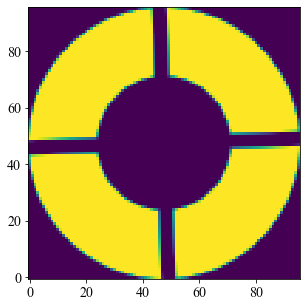

In [2]:
PSZ     =  96   # size of the array for the model
pdiam   = 4.646    # telescope diameter in meters

# pmask   = PHARO(PSZ, PSZ/2, mask="med")
oversample = 5
pmask  = PHARO(PSZ*(2**oversample), (2**oversample)*PSZ/2, mask="med", ang=-2) # rotated!
def half_bin(array):
    return (array[::2,::2] + array[1::2,::2] + array[::2,1::2] + array[1::2,1::2])/4.

for j in range(oversample):
    pmask = half_bin(pmask)
ppscale = pdiam / PSZ


# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask)
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/PHARO/rotated_pupil.png")
# -------------------------



In [3]:
pharo = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=pmask,
                               pixelscale=ppscale,
                               name='pharo',planetype=1)
pharo.pupil_diam = pdiam

In [4]:
WAVELENGTH = 2.145e-6
RADIUS = pdiam/2. # meters
PIXSCALE = 0.025 # arcsec / pix
NWAVES = 1.0
ISZ = 64
FOV = ISZ*PIXSCALE # arcsec
NPIX = PSZ#96


osys = morphine.OpticalSystem(npix=PSZ)
osys.add_pupil(pharo)    
osys.pupil_diameter = pdiam
pscale = 0.025
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)  # image plane coordinates in arcseconds
osys.source_offset_r = 0*pscale
osys.source_offset_theta = 0

In [5]:
psf,intermediate = osys.propagate_mono(WAVELENGTH)

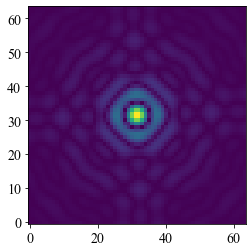

In [6]:
plt.imshow(psf.intensity**0.5)

In [7]:
psf.intensity.shape

(64, 64)

In [8]:
m2pix = xara.core.mas2rad(pscale*1000.) * ISZ / WAVELENGTH
print('m2pix =',m2pix)

m2pix = 3.616325826458078


In [9]:
u = np.linspace(-pdiam,pdiam,NPIX)
uu, vv = np.meshgrid(u,u)

In [10]:
dft1 = xara.core.compute_DFTM1(onp.array([uu.ravel(),vv.ravel()]).T,m2pix,psf.intensity.shape[0],offset=0.5)

In [11]:
# np.sqrt(dft1.shape[0]).astype('int')

In [109]:
def frantz_ft1(image,FF,norm=1):
    # norm is kpi.TRM.sum() / image.sum()
    myft_v = np.dot(FF,image.flatten())
    myft_v *= norm/image.sum()
    npix = np.sqrt(dft1.shape[0]).astype('int')
    return myft_v.reshape(npix,npix,order='F')

In [110]:
cvis1 = frantz_ft1(psf.intensity,dft1)

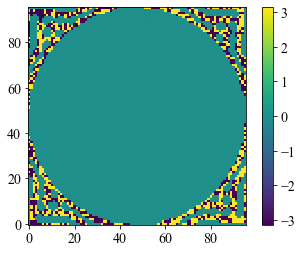

In [111]:
dummy = onp.copy(cvis1)#[32:96,32:96]
# plt.imshow(np.angle(cvis1))

plt.imshow(np.angle(dummy))
plt.colorbar()

## Non Zernike basis?

In [112]:
class mywavefront(morphine.ArrayOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


In [113]:
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(pmask))

In [114]:
pupil = osys.planes[0]


In [115]:
osys = morphine.OpticalSystem(npix=PSZ)
osys.add_pupil(pharo)    # pupil radius in meters
osys.pupil_diameter = pdiam

wf = osys.input_wavefront()
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(WAVELENGTH)

In [116]:
wf.amplitude.shape

(96, 96)

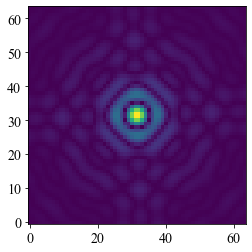

In [117]:
plt.imshow(psf.intensity**0.5)

## Now let's try to autodiff this

In [118]:
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = morphine.OpticalSystem(npix=PSZ)
    osys.add_pupil(pharo)
    osys.pupil_diameter = pdiam

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return frantz_ft1(psf.intensity,dft1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)

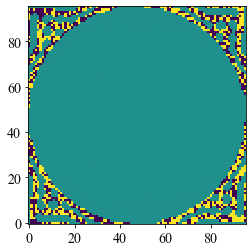

In [119]:
plt.imshow(output)

In [120]:
from jax import jacfwd, jacrev


In [121]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [122]:
# phasegrad = jacrev(uv_phase)

In [123]:
# %%memit 

# thisgrad = phasegrad(zero_phase)
# print(thisgrad.sum())


In [124]:
phasegrad = jacfwd(uv_phase)

In [ ]:
%%memit 
time = clock()
thisgrad = phasegrad(zero_phase)
print(thisgrad.sum())
print('Time taken:',(clock()-time)/60.,'min')

In [ ]:
otf = end_to_end(zero_phase)

In [ ]:
support = np.abs(otf) > 75.0e-4
plt.imshow(support)

In [ ]:
indices = 20

phases = onp.copy(thisgrad[:,:,indices,indices])
phases[support<1.] = np.nan
plt.imshow(phases,cmap=phasemap)


In [ ]:
indices = 20
pupil_trans = pmask
phasescreen_test = onp.zeros_like(pupil_trans)
phasescreen_test[indices,indices] = 0.1

plt.imshow(phasescreen_test)

In [ ]:
output = onp.array(uv_phase(phasescreen_test))
output[support<1.] = np.nan
plt.imshow(output,cmap=phasemap)


In [ ]:
np.floor((pmask.shape[0]/2)).astype('int')

In [ ]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 10
fs = 16

# mid = np.floor((pmask.shape[0]/2)).astype('int')
index_step = onp.floor((thisgrad.shape[3])/((3.*rows))).astype('int')

indices = index_step+2

for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[:,:,indices,indices])
        pupil_trans = pmask.copy()
        phases[support<1.] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil_trans)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
# plt.savefig('/Users/benjaminpope/code/morphine/paper/pharo_jacobian.pdf',bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(8,4))
columns = 4
rows = 1
indices = 10
fs = 16

# mid = np.floor((pmask.shape[0]/2)).astype('int')

indices_list = [(32,32),(96,48)]
for j in [0,1]:
    indices = indices_list[j]
    
    phases = onp.copy(thisgrad[:,:,indices[0],indices[1]])
    pupil_trans = pmask.copy()
    phases[support<1.] = np.nan
    ax[1+2*j].imshow(phases,cmap=phasemap)

    ax[1+2*j].set_xticks([])
    ax[1+2*j].set_yticks([])
    ax[1+2*j].set_title('u,v',fontsize=fs)
    ax[2*j].set_title('Pupil',fontsize=fs)

    ax[2*j].imshow(pupil_trans)
    ax[2*j].scatter(indices[0],indices[1],s=32,c='r')
    ax[2*j].set_xticks([])
    ax[2*j].set_yticks([])

    indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/pharo_jacobian.pdf',bbox_inches='tight')

In [ ]:
thisgrad.shape

In [ ]:
mid = np.round((NPIX+1)/2).astype('int')

half = onp.array(support).copy()
half[:,mid:] = 0

pupil_mask = (pupil_trans==1.)

In [ ]:
# transfer_martinache = thisgrad[:,:,support>0][pupil_trans==1,:].T

transfer = onp.array(thisgrad.reshape(((NPIX)**2),(PSZ)**2))

transfer = transfer[half.ravel()==1.,:]
transfer = transfer[:,pupil_mask.ravel()]
transfer = transfer[:,1:] # one free phase

In [ ]:
print(transfer.shape)

In [ ]:
print(pupil_mask.shape)

In [ ]:
print(transfer)

In [ ]:
np.sum(pupil_mask)

In [ ]:
%%time
u1, s1, v1 = np.linalg.svd(transfer.T,full_matrices=True)

In [ ]:
# s1[6000]/s1[0]

In [ ]:
 u1.shape, v1.shape

In [ ]:
np.sum((s1/s1[0])>5e-8)


In [ ]:
first_k = np.min(np.where(s1/s1[0] == max(set(s1/s1[0]), key=list(s1/s1[0]).count)))

In [ ]:
nbuv = np.sum(half>0)
npupil = np.sum(pupil_trans.ravel()>0.)
nkphi = nbuv-first_k
neig = first_k

print('Summary of properties')
print('---------------------------------------------------------------')
print('- %d sub-apertures' % npupil)
print('- %d distinct baselines' % nbuv)
print('- %d Ker-phases (%.1f %% target phase information recovery)' % (nkphi, 100*nkphi/nbuv))
print('- %d Eig-phases (%.1f %% wavefront information recovery)' % (neig,100*neig/npupil))
print('---------------------------------------------------------------')


In [ ]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0],label='Monochromatic')
plt.axvline(first_k,color=colours[1])
# plt.plot(broadband['S1'],label='Broadband')
# plt.plot(corona['S1'],label='Lyot Coronagraph')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=18,frameon=False)
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/pharo_kerphi_singular.pdf',bbox_inches='tight')

In [ ]:
u1.shape, v1.shape

In [ ]:
fig = plt.figure(figsize=(12.0,8.0))
plt.imshow((transfer),interpolation=None)

In [ ]:
kernel = v1[(first_k+1):,:]
null = np.dot(kernel,transfer)

In [ ]:
plt.hist(np.abs(transfer.ravel()),bins=100,label='Transfer');
plt.hist(np.abs(null.ravel()),bins=100,label='Kernel');

plt.xscale('log')
plt.yscale('log')
plt.legend()

### Verify this is a transfer matrix

In [ ]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)
plt.imshow(zernikes[-3,:,:],cmap=phasemap)


In [ ]:
mode = 5e-9*zernikes[-3,:,:]
result = uv_phase(mode)
dummy = onp.array(result)
dummy[half!=1] = np.nan

linear = (onp.dot(transfer,mode[pupil_mask][1:]))
toy = onp.array(onp.nan*result)
toy[half==1.] = linear

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].imshow(dummy,cmap=phasemap)
axes[0].set_title('Propagation')
axes[1].imshow(toy,cmap=phasemap)
axes[1].set_title('Linear')

### What do these kernel phase maps look like?

In [ ]:
index = first_k+50

mode = 1.*onp.array(half)
mode[half==1.] = v1[index,:]
mode[half!=1.] = np.nan

plt.imshow(mode,cmap=phasemap)

In [ ]:
index = 1501

pupil_mode = 1.*onp.array(pupil_trans)
pupil_mode[pupil_mask] = onp.append([0],u1[:,index])
pupil_mode[~pupil_mask] = np.nan

plt.imshow(pupil_mode,cmap=phasemap)

In [ ]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('u,v',fontsize=24,labelpad=24)

for j in range(nsets):
    mode = 1.*onp.array(half)
    mode[half>0] = v1[j*50,:]
    mode[half<=0] = np.nan

    axes[1,j].imshow(mode,cmap=phasemap)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_mask] *= onp.append([0],u1[:,j*50]) 
    wavefront[~pupil_mask] = np.nan
    axes[0,j].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/pharo_nonsingular_modes_mono.pdf',bbox_inches='tight')

In [ ]:
nsets = 4

fig, axes = plt.subplots(nsets,nsets,figsize=(10,10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    mode = 1.*onp.array(half)
    mode[half==1.] = v1[j*50+first_k,:]
    mode[half<1.] = np.nan

    axis.imshow(mode,cmap=phasemap)  
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/pharo_kernel_modes_mono.pdf',bbox_inches='tight')

### Now can we save this as a KPI?

In [ ]:
x = np.linspace(-pdiam/2.,pdiam/2.,PSZ)
xx, yy = np.meshgrid(x,x)

mask = onp.array([xx[pupil_mask], yy[pupil_mask],(pupil_trans[pupil_mask])]).T

# u = np.linspace(-pdiam,pdiam,NPIX)
# uu, vv = np.meshgrid(u,u)

uv_samp = onp.array([uu[half==1.], vv[half==1.]]).T



In [ ]:
np.sqrt((uv_samp**2).sum(axis=1)).max()/(pdiam)

In [ ]:
transfer.shape

In [ ]:
 data = {'name'   : 'pharomorphinefrantz_64bit_%dpix' % NPIX,
         'mask'   : mask.astype('float64'),
         'uv'     : uv_samp.astype('float64'),
         'TFM'    : transfer.astype('float64'),
         'KerPhi' : kernel.astype('float64'),
         'RED'    : otf[half==1.].astype('float64'),
         'support': half.astype('float64')}

In [ ]:
%%time
import gzip, pickle
print('saving to pharomorphinefrantz_64bit_%dpix.kpi.gz' % NPIX)
myf = gzip.GzipFile('pharomorphinefrantz_64bit_%dpix.kpi.gz' % NPIX, "wb")
pickle.dump(data, myf, -1)
myf.close()
print('saved')

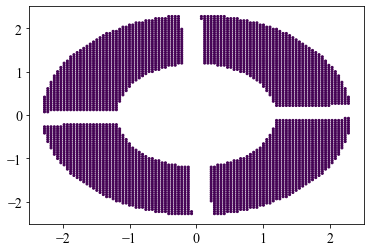

In [66]:
plt.scatter(mask[:,0],mask[:,1],c=mask[:,2],s=4)

In [67]:
import gzip, pickle
myf = gzip.GzipFile('pharomorphinefrantz.kpi.gz','r')
test = pickle.load(myf)
myf.close()

### Now let's see what a binary simulation looks like

In [68]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)



In [69]:
ISZ

64

In [70]:
coefficients_sequence = 15e-9*onp.random.randn(NZ)


aberrated = morphine.OpticalSystem(npix=PSZ)
aberrated.add_pupil(pharo)    # pupil radius in meters
aberrated.pupil_diameter = pdiam

thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
aberrated.add_pupil(thinlens)
aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=ISZ*PIXSCALE )

blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

In [71]:
(thinlens.get_opd(wf)).max()-(thinlens.get_opd(wf)).min()*1e9

DeviceArray(202.634672, dtype=float64)

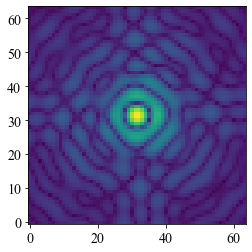

In [72]:
plt.imshow(blur.intensity**0.25)

In [73]:
offset = 0.125

aberrated.source_offset_r = offset
aberrated.source_offset_theta = 86
tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
aberrated.source_offset_r = 0


In [74]:
contrast = 1./50.
science = contrast*tilted.intensity+blur.intensity

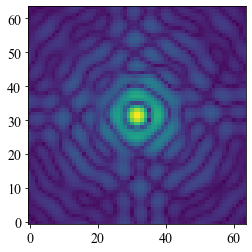

In [75]:
plt.imshow(science**0.25)

In [79]:
import pyfits
hdu = pyfits.PrimaryHDU(science)
hdulist = pyfits.HDUList([hdu])
hdulist.writeto('test_pharo.fits',clobber=True)


In [80]:
# do a bunch of them

seps = [75,100,125,150]
cons = [10,25,50]
thetas = [0,86,180,270]

for sep in seps:
    for theta in thetas:
        aberrated.source_offset_r = sep/1000.
        aberrated.source_offset_theta = theta
        tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
        for con in cons:
            science = 1./con*tilted.intensity+blur.intensity
            
            hdu = pyfits.PrimaryHDU(science)
            hdulist = pyfits.HDUList([hdu])
            fname = 'test_pharo_s%d_th%d_c%d.fits' % (sep,theta,con)
            hdulist.writeto(fname,clobber=True)
            print('Written to %s' % fname)


Written to test_pharo_s75_th0_c10.fits
Written to test_pharo_s75_th0_c25.fits
Written to test_pharo_s75_th0_c50.fits
Written to test_pharo_s75_th86_c10.fits
Written to test_pharo_s75_th86_c25.fits
Written to test_pharo_s75_th86_c50.fits
Written to test_pharo_s75_th180_c10.fits
Written to test_pharo_s75_th180_c25.fits
Written to test_pharo_s75_th180_c50.fits
Written to test_pharo_s75_th270_c10.fits
Written to test_pharo_s75_th270_c25.fits
Written to test_pharo_s75_th270_c50.fits
Written to test_pharo_s100_th0_c10.fits
Written to test_pharo_s100_th0_c25.fits
Written to test_pharo_s100_th0_c50.fits
Written to test_pharo_s100_th86_c10.fits
Written to test_pharo_s100_th86_c25.fits
Written to test_pharo_s100_th86_c50.fits
Written to test_pharo_s100_th180_c10.fits
Written to test_pharo_s100_th180_c25.fits
Written to test_pharo_s100_th180_c50.fits
Written to test_pharo_s100_th270_c10.fits
Written to test_pharo_s100_th270_c25.fits
Written to test_pharo_s100_th270_c50.fits
Written to test_pharo_

In [78]:
from tqdm import tqdm
# do a bunch of them
sep, theta, con = 125., 86., 25.
science = onp.zeros((100,ISZ,ISZ))

coefficients_sequence_0 = 15e-9*onp.random.randn(NZ)

for j in tqdm(range(100)):

    coefficients_sequence = 5e-9*onp.random.randn(NZ)+coefficients_sequence_0

    aberrated = morphine.OpticalSystem(npix=PSZ)
    aberrated.add_pupil(pharo)    # pupil radius in meters
    aberrated.pupil_diameter = pdiam

    thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
    aberrated.add_pupil(thinlens)
    aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=ISZ*PIXSCALE )

    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

    aberrated.source_offset_r = sep/1000.
    aberrated.source_offset_theta = theta
    tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    science[j,:,:] = 1./con*tilted.intensity+blur.intensity

hdu = pyfits.PrimaryHDU(science)
hdulist = pyfits.HDUList([hdu])
fname = 'test_pharo_s%d_th%d_c%d_cube.fits' % (sep,theta,con)
hdulist.writeto(fname,clobber=True)
print('Written to %s' % fname)


100%|██████████| 100/100 [00:05<00:00, 19.19it/s]

Written to test_pharo_s125_th86_c25_cube.fits
